In [4]:
%pylab inline
import torch
import numpy
import sklearn.datasets
import torchvision.datasets
import os
from scipy.misc import imresize as imgresize
from pycocotools import coco

torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Populating the interactive namespace from numpy and matplotlib


In [5]:
train_dest = "../../val2017"
target_dest = "../../annotations/instances_val2017_people.json"

In [6]:
# import json 
# spooky scary preprocessing
# with open("../../annotations/instances_val2017.json") as rfile, open("../../annotations/instances_val2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

# with open("../../annotations/instances_train2017.json") as rfile, open("../../annotations/instances_train2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

In [7]:
COCO = coco.COCO(target_dest)

def toMask(x):
    return np.sum(COCO.annToMask(i) > 0 for i in x)

def resizeNP(x):
    if type(x) == int and x == 0:
        return np.zeros((320, 320))
    return (imgresize(x, (320, 320), 'bilinear') > 0).astype(int)
    
def toTensor(x):
    return torch.from_numpy(x).float().unsqueeze(0)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [8]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((320, 320)), #реобразует картинку к указанному размеру
         torchvision.transforms.ToTensor()                   # Переводит объект "картинка" к torch.Tensor
    ])

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(toMask),
        torchvision.transforms.Lambda(resizeNP),
        torchvision.transforms.Lambda(toTensor),        
    ])

In [9]:
dataset = torchvision.datasets.CocoDetection(train_dest, target_dest, 
                                             transform=transforms, target_transform=train_transforms)

data_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    batch_size=4,
    num_workers=4)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


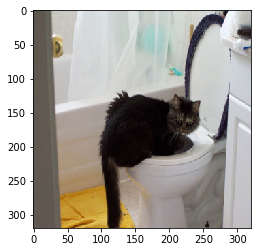

In [10]:
plt.imshow(dataset[3][0].numpy().swapaxes(0,1).swapaxes(1,2))
plt.show()

In [11]:
device = "cuda:0" if not torch.cuda.is_available() else "cpu"
print(device)

cpu


In [12]:
class UNetConvBlock(torch.nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU, pooling=True):
        super(UNetConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_layers, out_layers, kernel_size, padding=padding)
        self.conv2 = torch.nn.Conv2d(out_layers, out_layers, kernel_size, padding=padding)
        self.pooling = pooling
        self.pool = torch.nn.MaxPool2d(2)
        self.activation = activation()
        
    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.activation(self.conv2(out))
        if (self.pooling):
            out = self.pool(out)
        return out     
    
class UNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU):
        super(UNetUpConvBlock, self).__init__()
        self.upconv = torch.nn.Conv2d(in_layers, 4*in_layers, 1)
        self.transpose = torch.nn.ConvTranspose2d(4*in_layers, in_layers, 2, stride=2)
        self.conv = UNetConvBlock(in_layers, in_layers, pooling=False)  
        
    def forward(self, x):
        out = self.upconv(x)
        out = self.transpose(out)
        out = self.conv(out)
        return out    

def stack(old, new):
    return torch.cat([old, new], dim=1)

In [13]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = UNetConvBlock(3, 16)
        self.conv2 = UNetConvBlock(16, 32)
        self.conv3 = UNetConvBlock(32, 64)

        self.upconv3 = UNetUpConvBlock(64) 
        self.upconv2 = UNetUpConvBlock(96)  # stack with conv2 64 + 32
        self.upconv1 = UNetUpConvBlock(112) # stack with conv1 96 + 16
        
        self.fullconv = torch.nn.Conv2d(115, 1, 1) # with initial 112 + 3
        self.pred = torch.nn.Sigmoid()
        
    def forward(self, x):
        initial = x.clone()
        
        c1 = self.conv1(x)
        c2 = self.conv2(c1)          
        x = self.conv3(c2)
        
        x = self.upconv3(x)
        
        x = stack(c2, x)
        x = self.upconv2(x)
        
        x = stack(c1, x)
        x = self.upconv1(x)
        
        x = stack(initial, x)
        x = self.fullconv(x)  
        x = self.pred(x)
        return x

In [14]:
net = UNet()#.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

def intersection_over_union(pred, target):
    target = target > 0
    intersection = (pred * target > 0).sum().item()
    union = (pred + target > 0).sum().item() 
    return intersection / union

metric = intersection_over_union

In [15]:
for epoch in range(10):
    order = random.permutation(len(dataset.ids))
    net.train()
    for data, target in data_loader:
        optimizer.zero_grad()
        
        batch_features = data.to(device)
        batch_labels = target.to(device)
        
        batch_preds = net.forward(batch_features)

        loss = criterion(batch_preds, batch_labels)
        loss.backward()
        optimizer.step()
        
        print(loss)

Process Process-2:
Process Process-4:
Process Process-3:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process

KeyboardInterrupt: 

In [16]:
def showimgs(data_loader, net, batches=1):
    for i, (data, target) in enumerate(data_loader):
        pred = net.forward(data.to(device))
        for img_data, border_data, pred_data in zip(data, target, pred):
            fig, (img, border, prediction) = plt.subplots(1, 3)
            img.imshow(img_data.numpy().swapaxes(0,1).swapaxes(1,2))
            border.imshow(border_data.numpy().squeeze(0))
            prediction.imshow(pred_data.cpu().data.numpy().squeeze(0))
            plt.show()
        if (i == batches):
            break
        
def showpred(pred):
    for i in pred:
        plt.imshow(i.numpy().squeeze(0))
        plt.show()

In [17]:
showimgs(data_loader, net)
# torch.save(net.state_dict(), "state_dict.wght")

Process Process-5:
Process Process-8:
Process Process-6:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/teacher/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/teacher/.loca

KeyboardInterrupt: 

In [ ]:
from operator import itemgetter

def make_batch(dataset, order):
    items = itemgetter(*order)(dataset)
    data, targets = zip(*items)
    data = list(map(lambda x: x.unsqueeze(0), data))
    targets = list(map(lambda x: x.unsqueeze(0), targets))
    return torch.cat(data, dim=0), torch.cat(targets, dim=0)

test, target = make_batch(dataset, [i for i in range(4)])
test = test.to(device)
preds = net.forward(test).cpu().data > 0.2

preds[0]

In [ ]:
showpred(preds)
# test.shape

In [18]:
from PIL import Image

img = Image.open('test.png')
batch = transforms(img).unsqueeze(0)

In [20]:
net.forward(batch)

tensor([[[[ 0.5089,  0.5093,  0.5095,  ...,  0.5094,  0.5097,  0.5090],
          [ 0.5093,  0.5095,  0.5092,  ...,  0.5083,  0.5087,  0.5090],
          [ 0.5091,  0.5079,  0.5080,  ...,  0.5071,  0.5085,  0.5090],
          ...,
          [ 0.5090,  0.5092,  0.5086,  ...,  0.5055,  0.5047,  0.5046],
          [ 0.5088,  0.5092,  0.5089,  ...,  0.5049,  0.5046,  0.5042],
          [ 0.5086,  0.5089,  0.5084,  ...,  0.5047,  0.5040,  0.5043]]]])